# Continuous Control Report

---

Here, we will describe the reinforcement learning algorithm and the hyperparameters used to train the agent. We will also discuss possible improvements.

### Base Network Architecture

I used Deep Deterministic Policy Gradient algorithm, which consists of Actor network, responsible for policy improvement, and Critic network, responsible for value estimation. 

For the base Actor network, I used a feed-forward neural network using 3 `Linear` layers with `ReLU` activation functions and final `Tanh` activation function to bring the action values between -1 and 1. 

For the base Critic network, I used a feed-forward neural network using 4 `Linear` layers with `ReLU` activation functions. 1 `Linear` layer with activation function was used to extract features from the input state vector, which was concatenated with the previous action. Then, 3 `Linear` layers with `ReLU` activation functions were used to estimate the value of the state-action pair. 

Uniform Kaiming weight initialization with modification for `ReLU` activation was used for linear layers in both Actor and Critic networks.

In [ ]:
# Kaiming weight initialization for ReLU activation
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')    

# Actor, Critic classes adapted from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/model.py
# def hidden_init(layer):
#     fan_in = layer.weight.data.size()[0]
#     lim = 1. / np.sqrt(fan_in)
#     return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size),
            nn.Tanh()
        )
        self.reset_parameters()
        
    def reset_parameters(self):        
        self.model.apply(init_weights)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        return self.model(state)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, fc3_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model1 = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU()
        )
        self.model2 = nn.Sequential(
            nn.Linear(fc1_units+action_size, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc3_units),
            nn.ReLU(),
            nn.Linear(fc3_units, 1)
        )
        self.reset_parameters()
        
    def reset_parameters(self):
        self.model1.apply(init_weights)
        self.model2.apply(init_weights)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.model1(state)
        x = torch.cat((xs, action), dim=1)
        return self.model2(x)

### Implementation of DDPG with Replay Buffer

The implementation of DDPG with Replay Buffer used here was adapted from the architecture used during lesson exercises. DDPG architecture allows stable training by using "soft update", i.e. slow mixing of local weights into target weights controleld by the hyperparameter `tau`. 

The default choice of hyperparameters is specified in the `__init__` method. 

In [ ]:
BUFFER_SIZE = int(1e6)  # replay buffer size
WEIGHT_DECAY = 0.0001   # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent, OUNoise, and ReplayBuffer classes adapted from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/ddpg_agent.py
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128, fc3_units=128, batch_size=128, gamma=0.99, tau=1e-3, 
                 lr_actor=3e-4, lr_critic=3e-4, random_seed=42, actor_grad_clip=1e-1, critic_grad_clip=1e-1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
            batch_size (int): Batch size during training
            gamma (float): discount rate
            tau (float): rate of mixing local model weights into target model weights during soft update
            lr_actor (float): learning rate for actor networks
            lr_critic (float): learning rate for critic networks
            random_seed (int): random seed
            actor_grad_clip (float): gradient clipping for actor networks
            critic_grad_clip (float) gradient clipping for critic networks

        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.seed = random.seed(random_seed)
        self.actor_grad_clip = actor_grad_clip
        self.critic_grad_clip = critic_grad_clip

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, batch_size, random_seed)
        
        self.hard_update(self.actor_local, self.actor_target)
        self.hard_update(self.critic_local, self.critic_target)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(len(rewards)):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping for more stable training
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.critic_grad_clip)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # Gradient clipping for more stable training
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.actor_grad_clip)
        self.actor_optimizer.step()                  

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    # Hard update to sync the local and target models at the start of training 
    def hard_update(self, local_model, target_model):
        """Hard update model parameters, only called during agent's initialization
        θ_target = θ_local
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Hyperparameter Search

Here, I did not conduct a comprehensive hyperparameter search through all possible space of hyperparameters. Instead, I selected a reasonable set of hyperparameters, and experimented with changing only a few hyperparameters at a time. 

The plots from the hyperparameter search in the `Navigation.ipynb` are shown below for further discussion. Note that the plots are "smoothed" plots using sliding window averages of the trailing 100 scores.

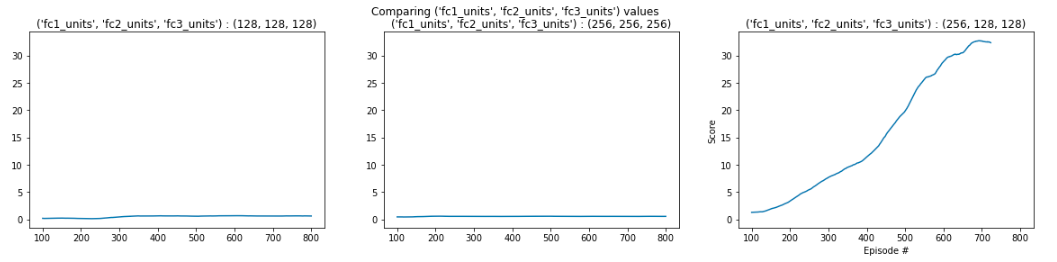

From the above plot of the combinations of number of units in different hidden layers, I settled on:
- 256 units for the first hidden layer and 128 units for the second hidden layer for the Actor network 
- 256 units for the first hidden layer (before concatenation of latent outputs for state vectors with action vectors), 128 units for the second hidden layer, and 128 units for the third hidden layer for the Critic network

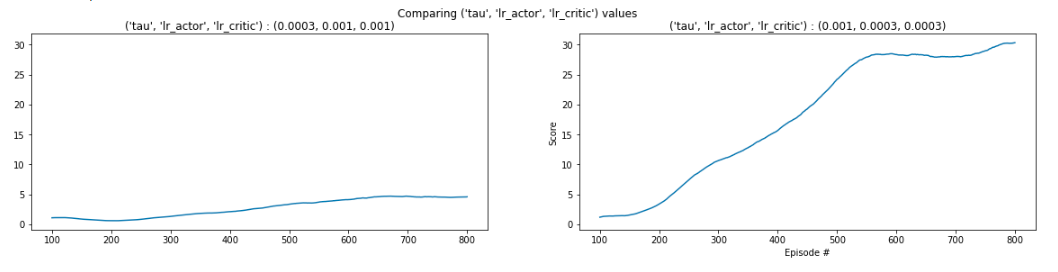

I used `tau` of `1e-3` for soft updates of both Actor and Critic networks and `lr_actor`, `lr_critic` of `3e-4` for the optimizers for the `actor_optimizer` and `critic_optimizer`. 

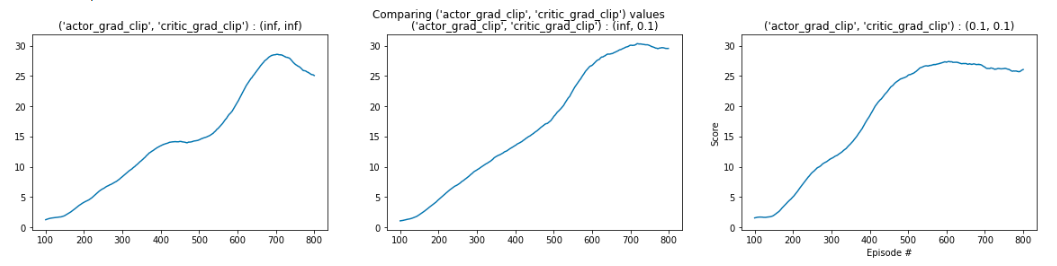

Gradient clipping was used with `torch.nn.utils.clip_grad_norm_()` to improve convergence during training. However, based on the above plot, gradient clipping was only used for the Critic network (by setting `max_norm=0.1`). For the Actor network, `torch.nn.utils.clip_grad_norm_()` with `max_norm=np.Inf` was used, so there was no gradient clipping. 

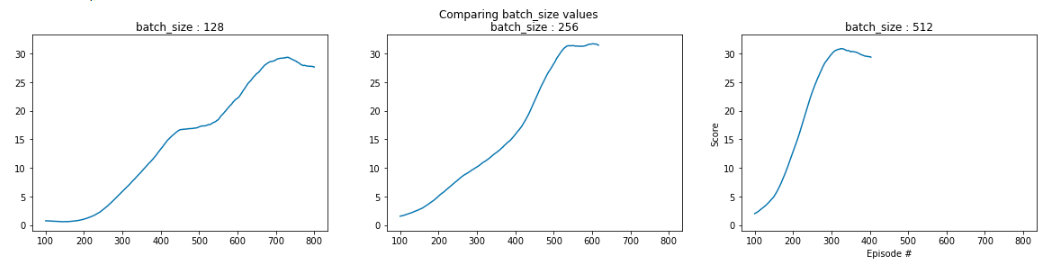

During hyperparameter search, default `batch_size` was set to 128 in order to speed up the hyperparameter search. However, based on the above plot, `batch_size=512` was used for the final training. 

## Final Training

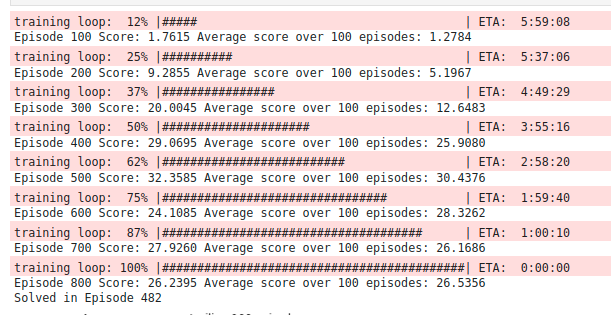

The first 800 episodes show that after 500 episodes, the average score over 20 agents over the trailing 100 consecutive episodes was > 30.

This is also shown in the below plots of the smoothed plot of the trailing 100 episodes, and the plot of the rewards at each individual episode.

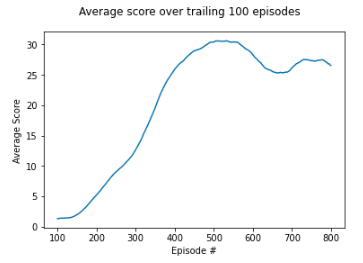

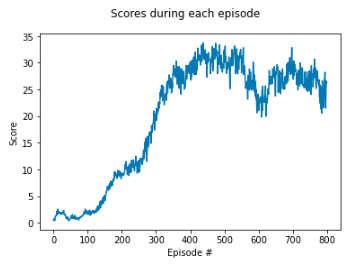

## Considerations for future improvement

Implementation of Proximal Policy Optimization algorithm, where the surrogate reward/loss function is clipped before gradient ascent/descent, would likely achieve better performance. In our implementation, gradient clipping was explored (not the clipping of surrogate function), which helped convergence during training but does not prevent overestimation of true reward function. 

Prioritized replay would also allow faster convergence of the policy learned by the Actor network, as well as policy evaluation by the Critic network, by sampling from the Replay Buffer more efficiently.